# Machine Learning - Lifecycle Samples
- Data load -> EDA -> Data Split -> Preprocessing -> Modeling -> Evaluation -> HPO -> Test

## Regression

### (1) Housing dataset

#### Data Load

In [78]:
housing = pd.read_csv('./handson-ml2/datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data Split

In [79]:
### 소득 별로 분할하여 Stratified split
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]
    
for set_ in (strat_train, strat_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [80]:
### split X, y
housing = strat_train.drop("median_house_value", axis=1)
housing_labels = strat_train["median_house_value"].copy()

In [81]:
### pipeline class
num_attribs = list(housing.columns.difference(["ocean_proximity"]))
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([ # compose
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

#### Modeling

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [83]:
### Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [86]:
### Pipeline with modeling
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(housing)

array([ 88983.14806384, 305351.35385026, 153334.71183453, ...,
       221487.30785916, 241041.31494299, 100662.66960931])

In [ ]:
### Another models
# Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# SVRegressor
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

#### Evaluation

In [85]:
### validation
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Decision Tree RMSE:', forest_rmse)

housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Random Forest RMSE:', forest_rmse)

housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('SVR RMSE:', np.sqrt(svm_rmse))

Random Forest RMSE: 18354.32660078079
SVR RMSE: 334.3690761684062


In [90]:
### Cross Validation
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

print('Tree model')
score = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-score) # error의 경우 부호를 반대로 해야 함
display_scores(tree_rmse_scores)

print('\nLinear Regression model')
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

print('\nRandom Forest model')
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

print('\nSVR model')
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Tree model
점수: [69849.95776875 69185.54836148 70489.07564732]
평균: 69841.52725918274
표준 편차: 532.1961739470247

Linear Regression model
점수: [68499.93941627 70177.76265488 69201.23113026]
평균: 69292.97773380253
표준 편차: 688.0338094636624

Random Forest model
점수: [49823.0556125  50532.45470069 51183.65349122]
평균: 50513.05460147205
표준 편차: 555.6311245051338

SVR model
점수: [112649.49881834 114393.2710437  115034.92596079]
평균: 114025.89860760847
표준 편차: 1007.8979918917704


#### HPO

In [91]:
### Grid search
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [92]:
print('best params:', grid_search.best_params_)
print('best estimator:', grid_search.best_estimator_)

best params: {'max_features': 8, 'n_estimators': 30}
best estimator: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params) # Grid search 점수 확인

63450.32381122495 {'max_features': 2, 'n_estimators': 3}
55928.62717586398 {'max_features': 2, 'n_estimators': 10}
53602.05766014793 {'max_features': 2, 'n_estimators': 30}
60274.67681804967 {'max_features': 4, 'n_estimators': 3}
53181.17799369876 {'max_features': 4, 'n_estimators': 10}
51088.77876908601 {'max_features': 4, 'n_estimators': 30}
61202.48392403287 {'max_features': 6, 'n_estimators': 3}
53165.830387170696 {'max_features': 6, 'n_estimators': 10}
50853.83092128557 {'max_features': 6, 'n_estimators': 30}
60352.1421257307 {'max_features': 8, 'n_estimators': 3}
52746.277456108925 {'max_features': 8, 'n_estimators': 10}
50727.14790838459 {'max_features': 8, 'n_estimators': 30}
62813.005687821016 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54973.79417527878 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60619.70682327377 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53622.092899649375 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [94]:
### Randomized search
param_distribs = {'n_estimators': np.random.randint(low=1, high=200, size=10),
                  'max_features': np.random.randint(low=1, high=8, size=10)}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': array([1, 4, 1, 4, 6, 2, 7, 2, 5, 7]),
                                        'n_estimators': array([ 89,  76,  86,  42, 190, 186, 160, 118, 134, 191])},
                   random_state=42, scoring='neg_mean_squared_error')

In [95]:
from scipy.stats import randint
from scipy.stats import geom, expon

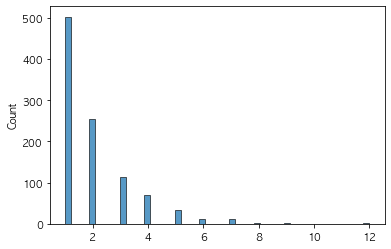

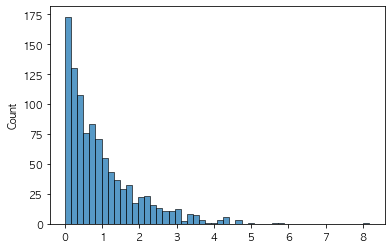

In [96]:
# geom, exponential parameters
geom_distrib = geom(0.5).rvs(1000, random_state=42)
expon_distrib = expon(scale=1).rvs(1000, random_state=42)

sns.distplot(geom_distrib, bins=50)
plt.show()
sns.distplot(expon_distrib, bins=50)
plt.show()

In [97]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50399.07388517163 {'n_estimators': 42, 'max_features': 5}
53151.49924606481 {'n_estimators': 42, 'max_features': 2}
52500.17992637956 {'n_estimators': 89, 'max_features': 2}
49790.8700008532 {'n_estimators': 186, 'max_features': 6}
49783.103660502886 {'n_estimators': 190, 'max_features': 6}
50126.67179647642 {'n_estimators': 191, 'max_features': 4}
54534.37226514882 {'n_estimators': 86, 'max_features': 1}
49832.77852609296 {'n_estimators': 89, 'max_features': 5}
50394.004875777195 {'n_estimators': 89, 'max_features': 4}
54493.35800093847 {'n_estimators': 89, 'max_features': 1}


In [98]:
### Best model, Feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4499147620859369, 'median_income'),
 (0.1401204552927923, 'pop_per_hhold'),
 (0.11308431493871018, 'longitude'),
 (0.10100077376373191, 'latitude'),
 (0.04900351622597163, 'housing_median_age'),
 (0.038638281268360365, 'population'),
 (0.030800756442082574, 'total_rooms'),
 (0.028466395086199844, 'total_bedrooms'),
 (0.02585907088468502, 'households'),
 (0.011619867281741325, 'rooms_per_hhold'),
 (0.009239103399093158, 'INLAND'),
 (0.00218027514438822, '<1H OCEAN'),
 (7.242818630655396e-05, 'bedrooms_per_room')]

#### Model Test

In [99]:
### Test set 사용
final_model = grid_search.best_estimator_

x_test = strat_test.drop("median_house_value", axis=1)
y_test = strat_test["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

print(mean_squared_error(y_test, final_predictions, squared=False))

47766.34153125065


In [100]:
# 95% CI for Test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
print(np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))))

# z-score
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(len(squared_errors))
print(np.sqrt(mean - zmargin), np.sqrt(mean + zmargin))

[45847.46771481 49611.05190076]
45848.04225163724 49610.52094316534


### (2) Boston dataset

In [200]:
x = boston[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']].values
y = boston['MEDV'].values

In [201]:
ridge_alphas = [0, 0.1, 1, 10, 100]

for param in ridge_alphas:
    model = Ridge(alpha=param)
    neg_mse_scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(x, y)

    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=model.coef_, index=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
    colname = 'alpha:' + str(param)

alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.773 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.741 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.645 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.555 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.347 


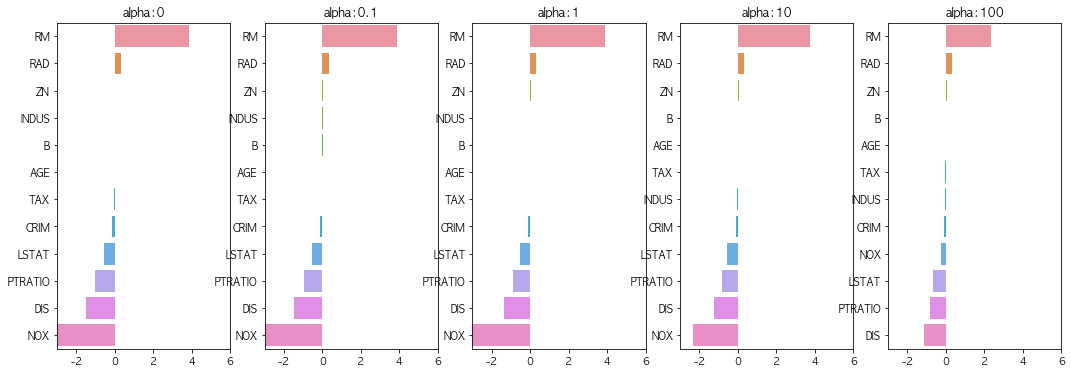

In [202]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 축 생성  
fig , axs = plt.subplots(figsize=(18, 6) , nrows=1 , ncols=5)
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(ridge_alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(x, y)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_, index=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
    colname='alpha:' + str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [203]:
# 반환된 coeff_ridge_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.850492,3.858334,3.890827,3.727496,2.339810
RAD,0.328311,0.325699,0.311668,0.296401,0.320815
ZN,0.047052,0.047197,0.048026,0.050017,0.054656
INDUS,0.040311,0.035732,0.010595,-0.027579,-0.047854
B,0.009741,0.009794,0.010074,0.010335,0.009486
AGE,0.002784,0.001832,-0.003288,-0.008940,0.001833
TAX,-0.013756,-0.013831,-0.014251,-0.015008,-0.016184
CRIM,-0.113139,-0.112582,-0.109545,-0.105290,-0.103453
LSTAT,-0.534158,-0.535288,-0.542158,-0.566095,-0.663160
PTRATIO,-0.990958,-0.979006,-0.914063,-0.828463,-0.838930


In [204]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환 
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    if scale_method[0]=='Standard':
        x_scaled = StandardScaler().fit_transform(x)
    elif scale_method[0]=='MinMax':
        x_scaled = MinMaxScaler().fit_transform(x)
    elif scale_method[0]=='Log':
        x_scaled = np.log1p(x)
    else:
        x_scaled = x

    if scale_method[1] != None: # p_degree
        x_scaled = PolynomialFeatures(degree=scale_method[1], include_bias=False).fit_transform(x_scaled)

    print(x_scaled.shape, x.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))

    for param in ridge_alphas:
        model = Ridge(alpha=param)
        neg_mse_scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(x, y)

        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
        coeff = pd.Series(data=model.coef_, index=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
        colname = 'alpha:' + str(param)

(506, 12) (506, 12)

## 변환 유형:None, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.773 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.741 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.645 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.555 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.347 
(506, 12) (506, 12)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.773 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.741 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.645 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.555 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.347 
(506, 90) (506, 12)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.773 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.741 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.645 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.555 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.347 
(506, 12) (506, 12)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0일 때 5 폴드 세트의 평균 RMSE: 5.773 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.741 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.645 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.555 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.347 
(506, 90) (506, 1

In [213]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]

coeff_df = pd.DataFrame()
for param in lasso_alphas:
    model = Lasso(alpha=param)
    neg_mse_scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(x, y)

    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=model.coef_, index=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
    colname = 'alpha:' + str(param)
    coeff_df[colname] = coeff

alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.631 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.627 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [214]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.809254,3.716204,2.498212,0.949811,0.000000
RAD,0.283357,0.282979,0.277451,0.264206,0.061864
ZN,0.049369,0.049418,0.049544,0.049165,0.037231
B,0.010467,0.010395,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.010392,-0.009162,0.003604,0.020910,0.042495
TAX,-0.015034,-0.015065,-0.015442,-0.015212,-0.008602
INDUS,-0.030656,-0.028984,-0.005253,-0.000000,-0.000000
CRIM,-0.101042,-0.099791,-0.083289,-0.063437,-0.000000
LSTAT,-0.565260,-0.571985,-0.656290,-0.761115,-0.807679


In [225]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_df = pd.DataFrame()

for param in elastic_alphas:
    model = ElasticNet(alpha=param)
    neg_mse_scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(x, y)

    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=model.coef_, index=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
    colname = 'alpha:' + str(param)
    coeff_df[colname] = coeff    

alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.532 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.500 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.413 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.522 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 5.954 


In [226]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.461602,3.264197,1.723609,0.933936,0.000000
RAD,0.295106,0.297253,0.311584,0.301569,0.199147
ZN,0.050970,0.051603,0.054045,0.053240,0.046018
B,0.010230,0.010112,0.008997,0.008339,0.007271
AGE,-0.007815,-0.006303,0.009475,0.020579,0.038926
TAX,-0.015304,-0.015465,-0.016300,-0.016439,-0.013587
INDUS,-0.035567,-0.038100,-0.031702,-0.012657,-0.000000
CRIM,-0.102876,-0.102033,-0.092503,-0.080371,-0.040903
NOX,-0.469266,-0.050892,-0.000000,-0.000000,-0.000000
LSTAT,-0.587466,-0.601659,-0.706176,-0.758426,-0.794154


In [441]:
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
neg_mse_scores = cross_val_score(dt_reg, x, y, scoring="neg_mean_squared_error", cv=5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE: {0:.3f} '.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores:  [-11.94 -36.25 -33.48 -46.05 -65.56]
5 교차 검증의 개별 RMSE scores:  [3.46 6.02 5.79 6.79 8.1 ]
5 교차 검증의 평균 RMSE: 6.029 


<AxesSubplot:>

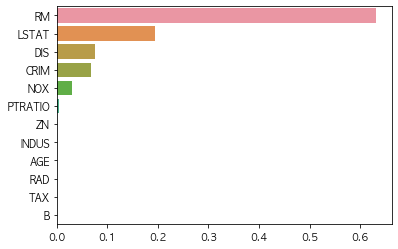

In [442]:
dt_reg.fit(x, y)
features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_series = pd.Series(data=dt_reg.feature_importances_, index=features)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


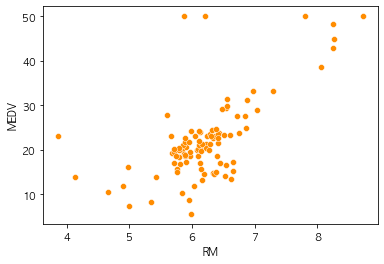

In [443]:
boston_sample = boston[['RM', 'MEDV']]
boston_sample = boston_sample.sample(n=100, random_state=0)
print(boston_sample.shape)

sns.scatterplot(x=boston_sample.RM, y=boston_sample.MEDV, color="darkorange")
plt.show()

In [444]:
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
x_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 Price 추출
x_feature = boston_sample['RM'].values.reshape(-1, 1)
y_target = boston_sample['MEDV'].values.reshape(-1, 1)

# 학습과 예측 수행. 
rf_reg2.fit(x_feature, y_target)
rf_reg7.fit(x_feature, y_target)

pred_rf2 = rf_reg2.predict(x_test)
pred_rf7 = rf_reg7.predict(x_test)

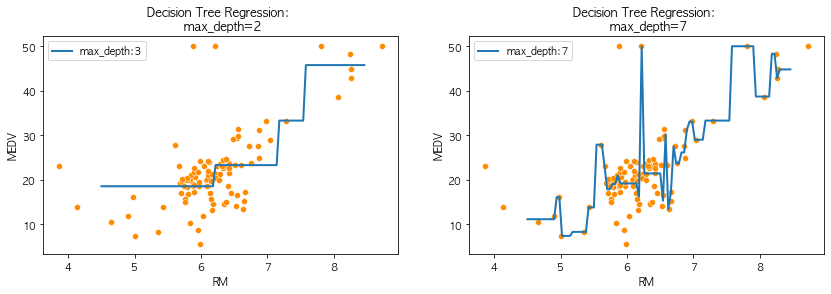

In [445]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 4), ncols=2)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 트리 회귀 예측 선 시각화
# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax1.set_title('Decision Tree Regression: \n max_depth=2')
sns.scatterplot(x=boston_sample.RM, y=boston_sample.MEDV, color="darkorange", ax=ax1)
sns.lineplot(x=x_test.reshape(1, -1)[0], y=pred_rf2.reshape(1, -1)[0], label="max_depth:3", linewidth=2, ax=ax1)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=7')
sns.scatterplot(x=boston_sample.RM, y=boston_sample.MEDV, color="darkorange", ax=ax2)
sns.lineplot(x=x_test.reshape(1, -1)[0], y=pred_rf7.reshape(1, -1)[0], label="max_depth:7", linewidth=2, ax=ax2)
plt.show()

## Classification

### (1) Mnist dataset

In [101]:
from sklearn.datasets import fetch_openml

In [102]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

x, y = mnist["data"], mnist["target"]
print(x.shape, y.shape)

(70000, 784) (70000,)


In [103]:
# y type 변환
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

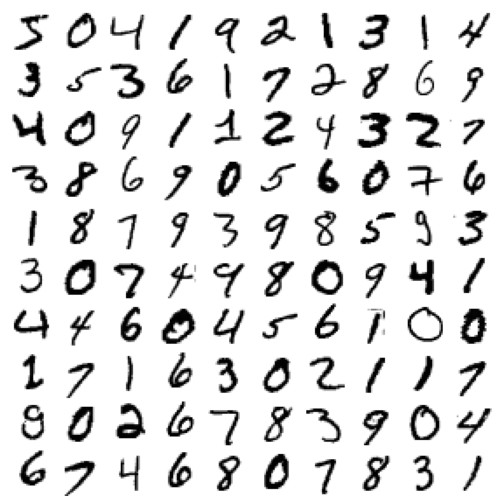

In [104]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다.
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다.
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = x[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

#### Preprocessing

In [105]:
### Data split
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [106]:
### Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

#### Modeling - Binary

In [107]:
### Biranry case로 변경
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [108]:
from sklearn.linear_model import SGDClassifier

In [109]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train_scaled, y_train_5)

SGDClassifier(random_state=42)

#### Evaluation

In [ ]:
### Cross Valication
cross_val_score(sgd_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy") ### 아래의 Base model과 비교 필요

In [111]:
from sklearn.base import BaseEstimator

In [112]:
### Base model
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [113]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3)

In [114]:
confusion_matrix(y_train_5, y_train_pred)

array([[53931,   648],
       [ 1231,  4190]])

In [115]:
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1-score:", f1_score(y_train_5, y_train_pred))

Precision: 0.8660603555188094
Recall: 0.7729201254381111
F1-score: 0.8168437469538942


In [116]:
### score 추출
y_scores = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3, method="decision_function")

In [117]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

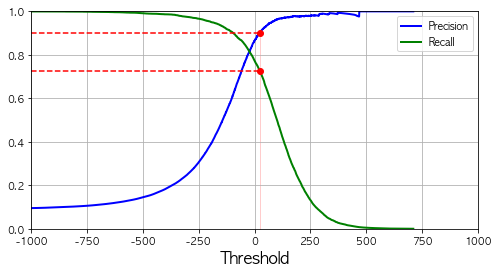

In [118]:
# 90% precision 목표
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
sns.lineplot(x=thresholds, y=precisions[:-1], color='blue', label="Precision", linewidth=2)
sns.lineplot(x=thresholds, y=recalls[:-1], color='green', label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.axis([-1000, 1000, 0, 1])   
plt.grid(True) 

sns.lineplot(x=[threshold_90_precision, threshold_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[-1000, threshold_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed') 
sns.lineplot(x=[-1000, threshold_90_precision], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[threshold_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

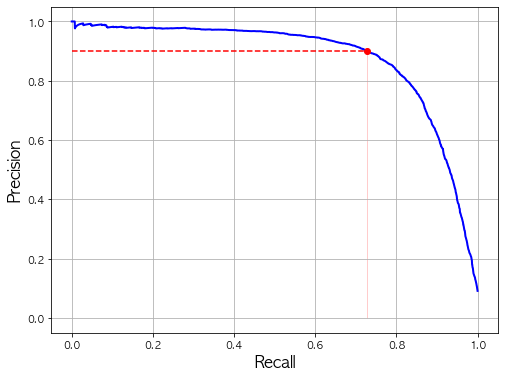

In [119]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=recalls, y=precisions, color="blue", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.grid(True)
    
sns.lineplot(x=[recall_90_precision, recall_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, recall_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[recall_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [120]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

22.472524841848383

In [121]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))
print("F1-score:", f1_score(y_train_5, y_train_pred_90))

Precision: 0.9000456412596988
Recall: 0.7275410440878067
F1-score: 0.804651637253902


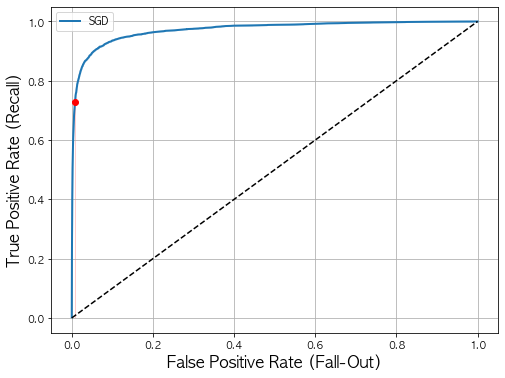

AUC: 0.9726681225154626


In [122]:
### ROC curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6)) 
sns.lineplot(x=fpr, y=tpr, linewidth=2, label='SGD')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")  
plt.show()

print('AUC:', roc_auc_score(y_train_5, y_scores))

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
### Add classifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [125]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3)

print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))
print("F1-score:", f1_score(y_train_5, y_train_pred_forest))

Precision: 0.9905083315756169
Recall: 0.8662608374838591
F1-score: 0.9242275142688446


In [126]:
y_probas_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
print('AUC:', roc_auc_score(y_train_5, y_scores_forest))

AUC: 0.9983414120257013


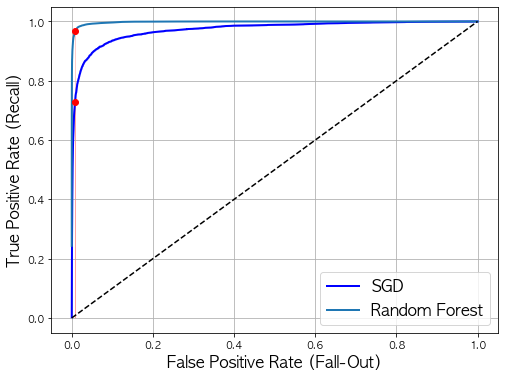

In [127]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, color='blue', linewidth=2, label="SGD")
sns.lineplot(x=fpr_forest, y=tpr_forest, linewidth=2, label="Random Forest")
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)
    
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_for_forest], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### (2) Pima diabete dataset

In [256]:
diabetes_data = pd.read_csv('./data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [257]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [258]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


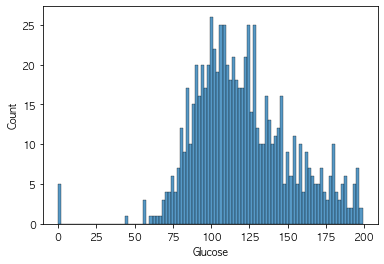

In [259]:
sns.histplot(diabetes_data['Glucose'], bins=100)
plt.show()

In [260]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [261]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [262]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
x = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(x_train , y_train)

pred = lr_clf.predict(x_test)
pred_proba = lr_clf.predict_proba(x_test)[:, 1]

confusion = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred_proba)
    
print('오차 행렬')
print(confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433


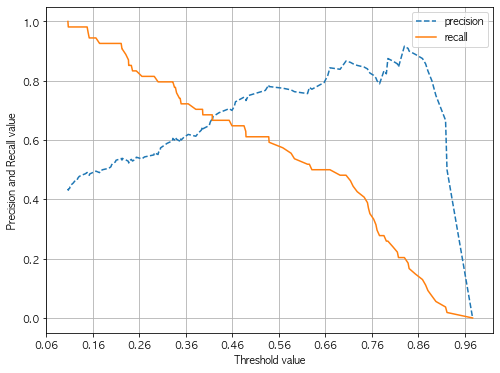

In [263]:
pred_proba_c1 = lr_clf.predict_proba(x_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [264]:
thresholds = [0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(x_test)[:, 1].reshape(-1, 1)

for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba) 
    custom_predict = binarizer.transform(pred_proba)
    print('임곗값:',custom_threshold)

    confusion = confusion_matrix(y_test, custom_predict)
    accuracy = accuracy_score(y_test, custom_predict)
    precision = precision_score(y_test, custom_predict)
    recall = recall_score(y_test, custom_predict)
    f1 = f1_score(y_test, custom_predict)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433


In [265]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba) 

confusion = confusion_matrix(y_test, pred_th_048)
accuracy = accuracy_score(y_test, pred_th_048)
precision = precision_score(y_test, pred_th_048)
recall = recall_score(y_test, pred_th_048)
f1 = f1_score(y_test, pred_th_048)
roc_auc = roc_auc_score(y_test, pred_proba)
    
print('오차 행렬')
print(confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433


### (3) StageC dataset

In [405]:
stagec = pd.read_csv('./data/stagec.csv')

In [406]:
stagec.isna().sum()

pgtime     0
pgstat     0
age        0
eet        2
g2         7
grade      0
gleason    3
ploidy     0
dtype: int64

In [407]:
### dropNA
stagec = stagec.dropna()
stagec.head()

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy
0,6.1,0,64,2.0,10.26,2,4.0,diploid
2,5.2,1,59,2.0,9.99,3,7.0,diploid
3,3.2,1,62,2.0,3.57,2,4.0,diploid
4,1.9,1,64,2.0,22.56,4,8.0,tetraploid
5,4.8,0,69,1.0,6.14,3,7.0,diploid


In [408]:
### Data split
x_train, x_test, y_train, y_test = train_test_split(stagec.drop('ploidy', axis=1), stagec['ploidy'], test_size=0.2, random_state=0, stratify=stagec['ploidy'])

In [409]:
dtree_clf = DecisionTreeClassifier(max_depth=3, random_state=100)
dtree_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=100)

In [410]:
pred = dtree_clf.predict(x_test)
test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)

print(test_cm)
print('정확도\t{}%'.format(round(test_acc *100,2)))

[[ 0  1  0]
 [ 1 12  0]
 [ 0  0 13]]
정확도	92.59%


In [411]:
feature_columns = list(stagec.columns.difference(['ploidy']))

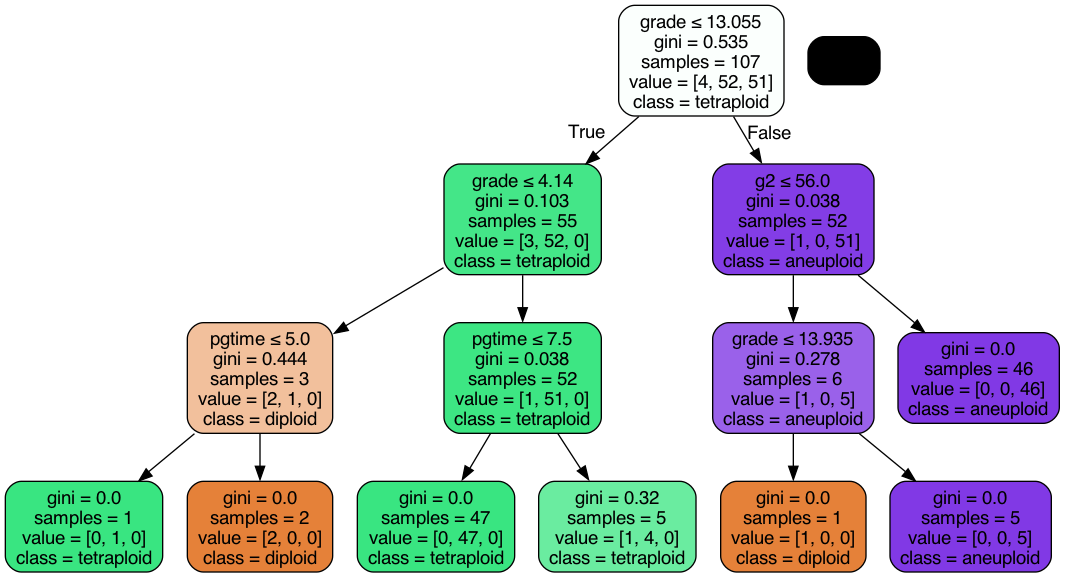

In [412]:
### Tree 시각화
feature_names = feature_columns
target_names = np.array(list(stagec.ploidy.unique()))

dt_dot_data = export_graphviz(dtree_clf, feature_names = feature_names,
                              class_names = target_names,
                              filled=True, rounded =True,
                              special_characters=True)
dt_graph=pydotplus.graph_from_dot_data(dt_dot_data)
Image(dt_graph.create_png())

### (4) Human activity dataset

In [413]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [414]:
# feature 중복 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [415]:
def get_human_dataset():
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    feature_dup_df = pd.DataFrame(data=feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name)
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [416]:
print('## 학습 피처 데이터셋 info()')
print(x_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [417]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [418]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [419]:
params = {'max_depth': [6, 8 ,10, 12, 16 ,20, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=3, verbose=1)
grid_cv.fit(x_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
GridSearchCV 최고 평균 정확도 수치:0.8473
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 6}


In [420]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847251
1,8,0.837323
2,10,0.830111
3,12,0.827663
4,16,0.825352
5,20,0.828344
6,24,0.828344


In [421]:
max_depths = [6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(x_train, y_train)
    pred = dt_clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [422]:
params = {'max_depth' : [8 , 12, 16, 20], 'min_samples_split' : [16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [423]:
best_df_clf = grid_cv.best_estimator_
pred = best_df_clf.predict(x_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


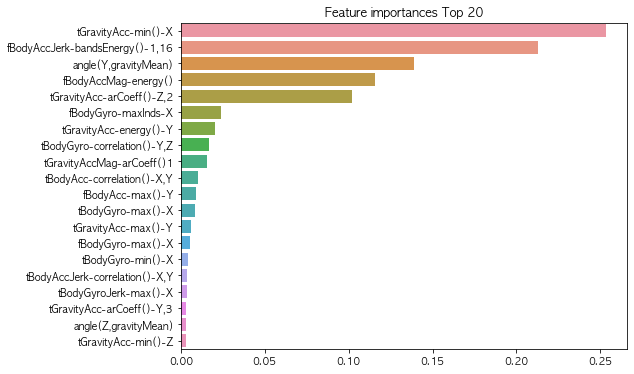

In [424]:
ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### (5) Santander bank dataset

In [511]:
cust_df = pd.read_csv("./data/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [512]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [513]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [514]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [515]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
x_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(x_features.shape))

피처 데이터 shape:(76020, 369)


In [516]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(x_train.shape, x_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

# x_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
# n_estimators는 50으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 20으로 설정하고 학습 수행.
# label 비율이 비대칭이므로
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc', eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [518]:
# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [519]:
# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=30, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(x_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc',
                   eval_set=[(x_tr, y_tr), (x_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(x_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=5, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30)) # random number generator

print('best:', best)

In [ ]:
# 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5))

# evaluation metric을 auc로, early stopping은 20 으로 설정하고 학습 수행. 
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric="auc",eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

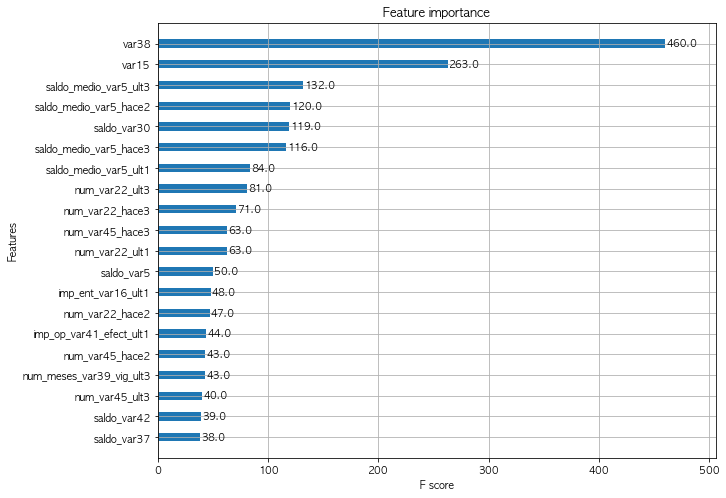

In [522]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=50)

eval_set=[(x_tr, y_tr), (x_val, y_val)]
lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[41]	training's auc: 0.910173	training's binary_logloss: 0.112442	valid_1's auc: 0.831852	valid_1's binary_logloss: 0.135272
ROC AUC: 0.8386


In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=50, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # x_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(x_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=5, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5))

# evaluation metric을 auc로, early stopping은 20 으로 설정하고 학습 수행. 
lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, callbacks=[early_stopping(stopping_rounds=20, first_metric_only=False)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	training's auc: 0.912105	training's binary_logloss: 0.112927	valid_1's auc: 0.830226	valid_1's binary_logloss: 0.135608
ROC AUC: 0.8394


### (6) Infert dataset

In [111]:
### Infert data
infert = pd.read_csv('./r_csv/datasets/infert.csv', index_col='Unnamed: 0')
infert.head()

,education,age,parity,induced,case,spontaneous,stratum,pooled.stratum
1,0-5yrs,26,6,1,1,2,1,3
2,0-5yrs,42,1,1,1,0,2,1
3,0-5yrs,39,6,2,1,0,3,4
4,0-5yrs,34,4,2,1,0,4,2
5,6-11yrs,35,3,1,1,1,5,32


In [112]:
### Data split
x_train, x_test, y_train, y_test = train_test_split(infert.drop(['case', 'education', 'stratum', 'pooled.stratum'], axis=1), infert['case'], test_size=0.2, random_state=0, stratify=infert['case'])

In [113]:
### Modeling
mlp = MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(2, 1), random_state=1)
mlp.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(2, 1), random_state=1,
              solver='lbfgs')

In [114]:
# 이 모델은 이상해요..
pred = mlp.predict(x_test)
test_cm = confusion_matrix(y_test, pred)
test_acc = accuracy_score(y_test, pred)
test_prc = precision_score(y_test, pred, average=None)
test_rcll = recall_score(y_test, pred, average=None)
test_f1 = f1_score(y_test, pred, average=None)

print(test_cm)
print('정확도\t{}'.format(test_acc))
print('정밀도\t{}'.format(test_prc))
print('재현율\t{}'.format(test_rcll))
print('F1\t{}%'.format(test_f1))

[[33  0]
 [17  0]]
정확도	0.66
정밀도	[0.66 0.  ]
재현율	[1. 0.]
F1	[0.79518072 0.        ]%


In [115]:
mlp.coefs_

[array([[-0.16595579, -0.34258659],
        [-0.99977002, -0.44743523],
        [-0.70648735, -0.8293321 ],
        [-0.62747881, -0.31839271]]),
 array([[-0.22855215],
        [-0.07187944]]),
 array([[1.10189376]])]

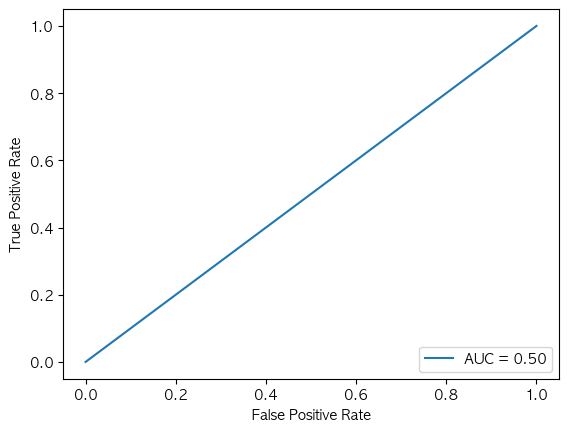

In [116]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
# plot_roc_curve(mlp, x_test, y_test) # plot_roc_curve
plt.show()

### (7) Breast cancer dataset

In [ ]:
from sklearn.datasets import load_breast_cancer

In [267]:
### Breast cancer data
cancer = load_breast_cancer()

In [268]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

x_train, x_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [269]:
# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_preds = lr_clf.predict(x_test)

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test , lr_preds)))

accuracy: 0.977, roc_auc:0.972


In [270]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(x_train, y_train)
    lr_preds = lr_clf.predict(x_test)
    
    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test , lr_preds)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.972
solver:liblinear, accuracy: 0.982, roc_auc:0.979
solver:newton-cg, accuracy: 0.977, roc_auc:0.972
solver:sag, accuracy: 0.982, roc_auc:0.979
solver:saga, accuracy: 0.982, roc_auc:0.979


In [271]:
params={'solver':['liblinear', 'lbfgs'], 'penalty':['l2', 'l1'], 'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression()
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


### (8) Loan default dataset

In [349]:
loan200 = pd.read_csv("./Practical_Statictics/data/loan200.csv")

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]

In [350]:
x = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]
pd.concat([x, y], axis=1)

,payment_inc_ratio,dti,outcome
1,5.46933,21.33,default
2,6.90294,8.97,paid off
3,11.14800,1.83,paid off
4,3.72120,10.81,default
5,1.89923,11.34,paid off
...,...,...,...
196,11.66300,26.09,default
197,2.97641,16.41,default
198,1.96846,19.98,default
199,9.64200,20.17,paid off


In [351]:
from sklearn.neighbors import KNeighborsClassifier

In [352]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x, y)

print(knn.predict_proba(newloan)) # predict 함수는 사용 불가

[[0.45 0.55]]


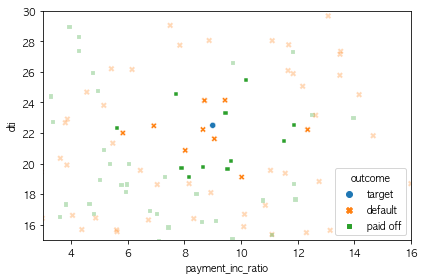

In [353]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', hue='outcome', data=loan200, alpha=0.3)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', hue='outcome', data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), legend=False)
plt.xlim(3, 16)
plt.ylim(15, 30)

plt.tight_layout()
plt.show()

In [354]:
### Add scaler
loan_data = pd.read_csv("./Practical_Statictics/data/loan_data.csv.gz")
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], categories=['paid off', 'default'], ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]

x = loan_data.loc[:, predictors]
y = loan_data.loc[:, outcome]

In [355]:
scaler = StandardScaler()
scaler.fit(x * 1.0)

x_std = scaler.transform(x * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_std, y)

nbrs = knn.kneighbors(newloan_std)
x.iloc[nbrs[1][0], :].head()

,payment_inc_ratio,dti,revol_bal,revol_util
0,2.39320,1.00,1687,9.4
2080,2.61091,1.03,1218,9.7
1438,2.34343,0.51,278,9.9
30215,2.71200,1.34,1075,8.5
28542,2.39760,0.74,2917,7.4


In [356]:
### KNN as a feature
loan_data['borrower_score'] = knn.predict_proba(x)[:, 0]
print(loan_data['borrower_score'].describe())

count    45342.000000
mean         0.502365
std          0.024868
min          0.300000
25%          0.500000
50%          0.500000
75%          0.500000
max          0.950000
Name: borrower_score, dtype: float64


array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

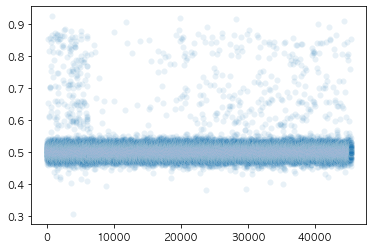

In [357]:
sns.scatterplot(x=range(len(x)), y=[bs + random.gauss(0, 0.015) for bs in knn.predict_proba(x)[:, 0]], alpha=0.1)
knn.predict_proba(x)[:, 0]

### (9) IMDB dataset

In [47]:
from keras.datasets import imdb

2023-08-31 13:14:57.387867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()

In [49]:
### word index to text
word_to_index = imdb.get_word_index()
index_to_word = {}

for key, value in word_to_index.items():
    index_to_word[value + 3] = key
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

train_reviews = []
for x in x_train:
    tmp =' '.join([index_to_word[index] for index in x])
    train_reviews.append(tmp)

test_reviews = []
for x in x_test:
    tmp =' '.join([index_to_word[index] for index in x])
    test_reviews.append(tmp)

train = pd.concat([pd.DataFrame(train_reviews), pd.DataFrame(y_train)], axis =1)
train.columns = ['reviews', 'label']
train['reviews'] = train['reviews'].str[6:]

test = pd.concat([pd.DataFrame(test_reviews), pd.DataFrame(y_test)], axis =1)
test.columns = ['reviews', 'label']
train['reviews'] = train['reviews'].str[6:]

print("<<<<<<<<< Train Dataset for MNB >>>>>>>>>", train)
print("<<<<<<<<< Test Dataset for MNB >>>>>>>>>", test)

<<<<<<<<< Train Dataset for MNB >>>>>>>>>                                                  reviews  label
0      ilm was just brilliant casting location scener...      1
1      ir big boobs bad music and a giant safety pin ...      0
2      as to be one of the worst films of the 1990s w...      0
3      ots excel at storytelling the traditional sort...      1
4      mistake of my life br br i picked this movie u...      0
...                                                  ...    ...
24995  s a racist movie but worthy of study and enjoy...      1
24996  ugosi plays a doctor who will do anything to k...      0
24997  ar away galaxy is a planet called ceta it's na...      0
24998  grees had me hooked i looked forward to it com...      1
24999  ig fan of the original film it's hard to watch...      0

[25000 rows x 2 columns]
<<<<<<<<< Test Dataset for MNB >>>>>>>>>                                                  reviews  label
0      <sos> please give this one a miss br br kristy...   

In [50]:
x_train, x_test = train['reviews'].values, test['reviews'].values
y_train, y_test = train['label'].values, test['label'].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
cv = CountVectorizer(binary=False) # 개수 세기
x_traincv = cv.fit_transform(x_train)
x_traincv.shape

(25000, 76521)

In [53]:
print(cv.inverse_transform(x_traincv)[0])
print(cv.get_feature_names_out()[-10:])

['ilm' 'was' 'just' 'brilliant' 'casting' 'location' 'scenery' 'story'
 'direction' 'everyone' 'really' 'suited' 'the' 'part' 'they' 'played'
 'and' 'you' 'could' 'imagine' 'being' 'there' 'robert' 'redford' 'is'
 'an' 'amazing' 'actor' 'now' 'same' 'director' 'norman' 'father' 'came'
 'from' 'scottish' 'island' 'as' 'myself' 'so' 'loved' 'fact' 'real'
 'connection' 'with' 'this' 'film' 'witty' 'remarks' 'throughout' 'were'
 'great' 'it' 'much' 'that' 'bought' 'soon' 'released' 'for' 'retail'
 'would' 'recommend' 'to' 'watch' 'fly' 'fishing' 'cried' 'at' 'end' 'sad'
 'know' 'what' 'say' 'if' 'cry' 'must' 'have' 'been' 'good' 'definitely'
 'also' 'congratulations' 'two' 'little' 'boy' 'of' 'paul' 'children'
 'are' 'often' 'left' 'out' 'praising' 'list' 'think' 'because' 'stars'
 'play' 'them' 'all' 'grown' 'up' 'such' 'big' 'profile' 'whole' 'but'
 'these' 'should' 'be' 'praised' 'done' 'don' 'lovely' 'true' 'someone'
 'life' 'after' 'shared' 'us']
['était' 'état' 'étc' 'évery' 'êxtase'

In [54]:
mnb = MultinomialNB()
mnb.fit(x_traincv, y_train)

MultinomialNB()

In [55]:
x_testcv = cv.transform(x_test)
pred = mnb.predict(x_testcv)
acc = accuracy_score(y_test, pred)
print("Accuracy Score : ", acc)
print(classification_report(y_test, pred))

Accuracy Score :  0.81932
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     12500
           1       0.85      0.77      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

